In [1]:
import sys

sys.path.append("C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import logging
import cProfile
from tqdm.notebook import tqdm

import utils
import config
import strat_test

importlib.reload(utils)
importlib.reload(config)
importlib.reload(strat_test)

<module 'strat_test' from 'C:\\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\\strat_test\\__init__.py'>

In [2]:
# config
cfg = config.config
blist = cfg['universe']['black']
quote_dir = cfg['folder']['quote']

factor_dir = (
    'C:/Users/ifwha/OneDrive - CUHK-Shenzhen/'
    '桌面/工作/A05_指数编制/quote/QUOTE_INDUSTRY/assembler'
)

start_date = '2016-01-01'

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.grid'] = True
%config InlineBackend.figure_format = 'retina'

读取数据

INFO:__main__:Read FG with 2759 rows
INFO:__main__:Read FG with 2759 rows
INFO:__main__:Read hc with 2449 rows
INFO:__main__:Read hc with 2449 rows
INFO:__main__:Read i with 2553 rows
INFO:__main__:Read i with 2553 rows
INFO:__main__:Read j with 3159 rows
INFO:__main__:Read j with 3159 rows
INFO:__main__:Read jm with 2688 rows
INFO:__main__:Read jm with 2688 rows
INFO:__main__:Read rb with 3467 rows
INFO:__main__:Read rb with 3467 rows
INFO:__main__:Read SF with 2353 rows
INFO:__main__:Read SF with 2353 rows
INFO:__main__:Read SM with 2353 rows
INFO:__main__:Read SM with 2353 rows
INFO:__main__:Read SA with 1054 rows
INFO:__main__:Read SA with 1054 rows
INFO:__main__:Read ss with 1101 rows
INFO:__main__:Read ss with 1101 rows


<Axes: xlabel='date'>

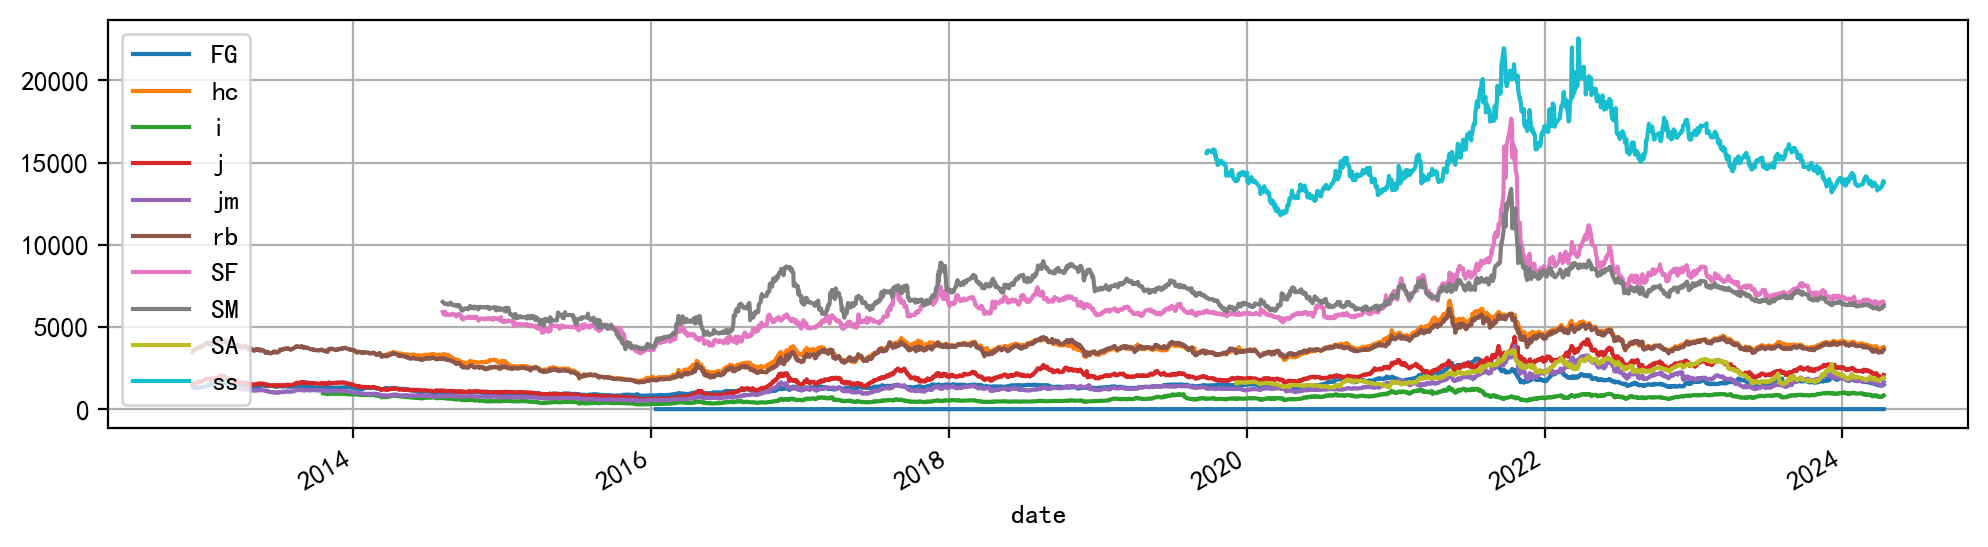

In [4]:
# futures data from quote basic
opens = pd.DataFrame()
closes = pd.DataFrame()

open_name = "open777"
close_name = "close777"

for v in blist:
    open_path = os.path.join(
        quote_dir, "QUOTE_BASIC", "assembler", open_name, f"{v}.csv"
    )
    open_df = pd.read_csv(open_path, index_col=0, parse_dates=True)
    open_df = open_df.loc[:]
    opens[v] = open_df[open_name]
    logger.info(f"Read {v} with {len(open_df)} rows")

    close_path = os.path.join(
        quote_dir, "QUOTE_BASIC", "assembler", close_name, f"{v}.csv"
    )
    close_df = pd.read_csv(close_path, index_col=0, parse_dates=True)
    close_df = close_df.loc[:]
    closes[v] = close_df[close_name]
    logger.info(f"Read {v} with {len(close_df)} rows")

# add nonferrous index
open_index_dir = os.path.join(quote_dir, "INDEX/black/black_oreturn_index_qb.csv")
black_open_index = pd.read_csv(open_index_dir, index_col=0, parse_dates=True)
opens["black"] = black_open_index

close_index_dir = os.path.join(quote_dir, "INDEX/black/black_creturn_index_qb.csv")
black_close_index = pd.read_csv(close_index_dir, index_col=0, parse_dates=True)
closes["black"] = black_close_index

# warrant data
warrant = pd.read_excel(
    "data/warrant/仓单数量螺纹钢等_20240627_110306.xlsx",
    index_col=0,
    header=1,
    parse_dates=True,
).shift(1)

warrant.columns = ["rb", "SM", "i", "SF", "hc", "j", "jm", "SA", "FG", "ss"]

opens.loc[:, opens.columns != "black"].plot()
(opens["black"]).plot()

简单看一下仓单数量数据，顺便试用一下 `plotly`

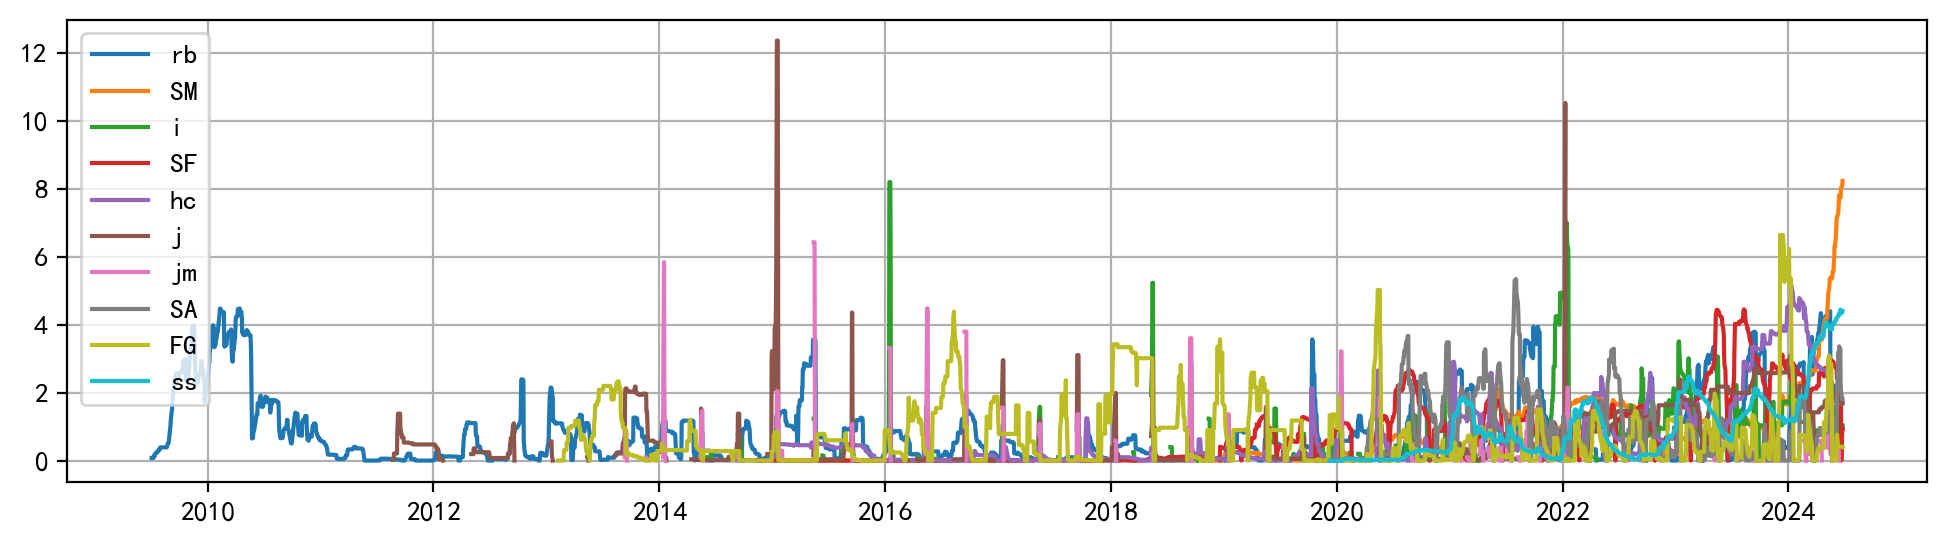

In [6]:
import plotly.express as px

# set theme
px.defaults.template = "ggplot2"

# px.line(utils.scale(warrant), title='仓单数量锡总计等_20240624_151242')
plt.plot(utils.scale(warrant, 'divstd'))
plt.legend(warrant.columns)

单品种择时回测，分别用本地数据自己测和用公司回测框架测试

In [29]:
variety = 'i'

warrant_diff = warrant.diff()
factor = warrant / warrant.rolling(5).mean() - 1

price, posi = opens[variety].align(factor[variety], join='inner')
price = price.loc[start_date:]
posi = posi.loc[start_date:]
posi = posi.div(posi.abs())
posi = posi.replace(np.nan, 0)
posi = -posi

nworth = strat_test.NetWorth(price, posi, fee=0.0002)

<Axes: >

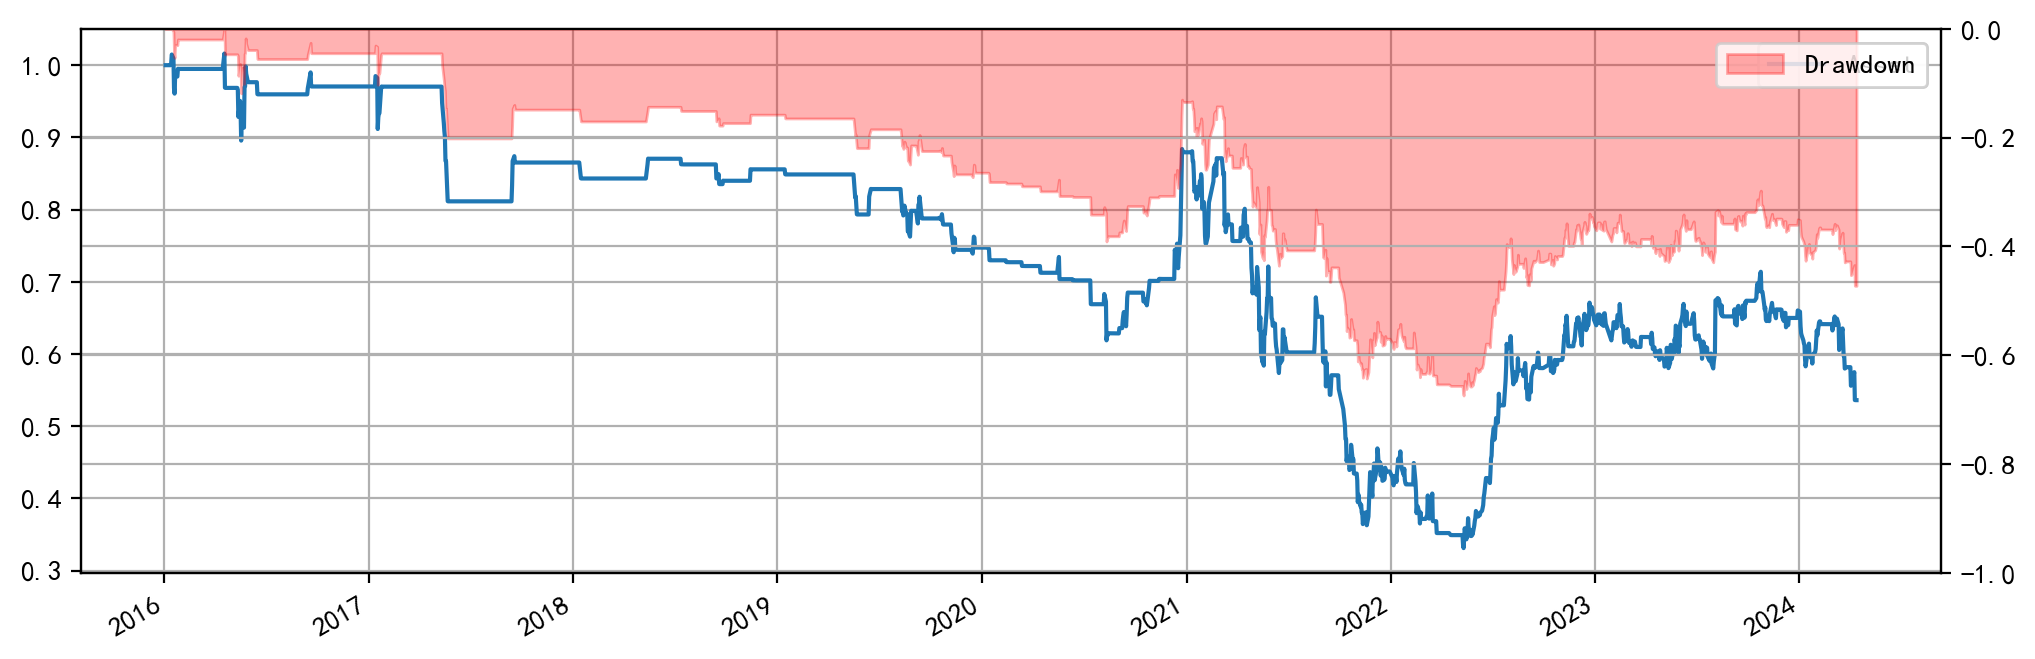

In [30]:
nworth.plot()

In [ ]:
cross_posi = utils.few2crossing(posi)
cross_posi.to_csv(f"data/position/warrant_{variety}.csv")

保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant_cu\warrant_cu_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant_cu\warrant_cu_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant_cu\warrant_cu.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant_cu\warrant_cu.csv
Figure(1200x800)
年化收益率 年化波动率 夏普率 最大回撤  最长回撤期 年换手率
    2.621%    13.675% 0.1917 -31.872%         917 4447.36%


<Axes: xlabel='0'>

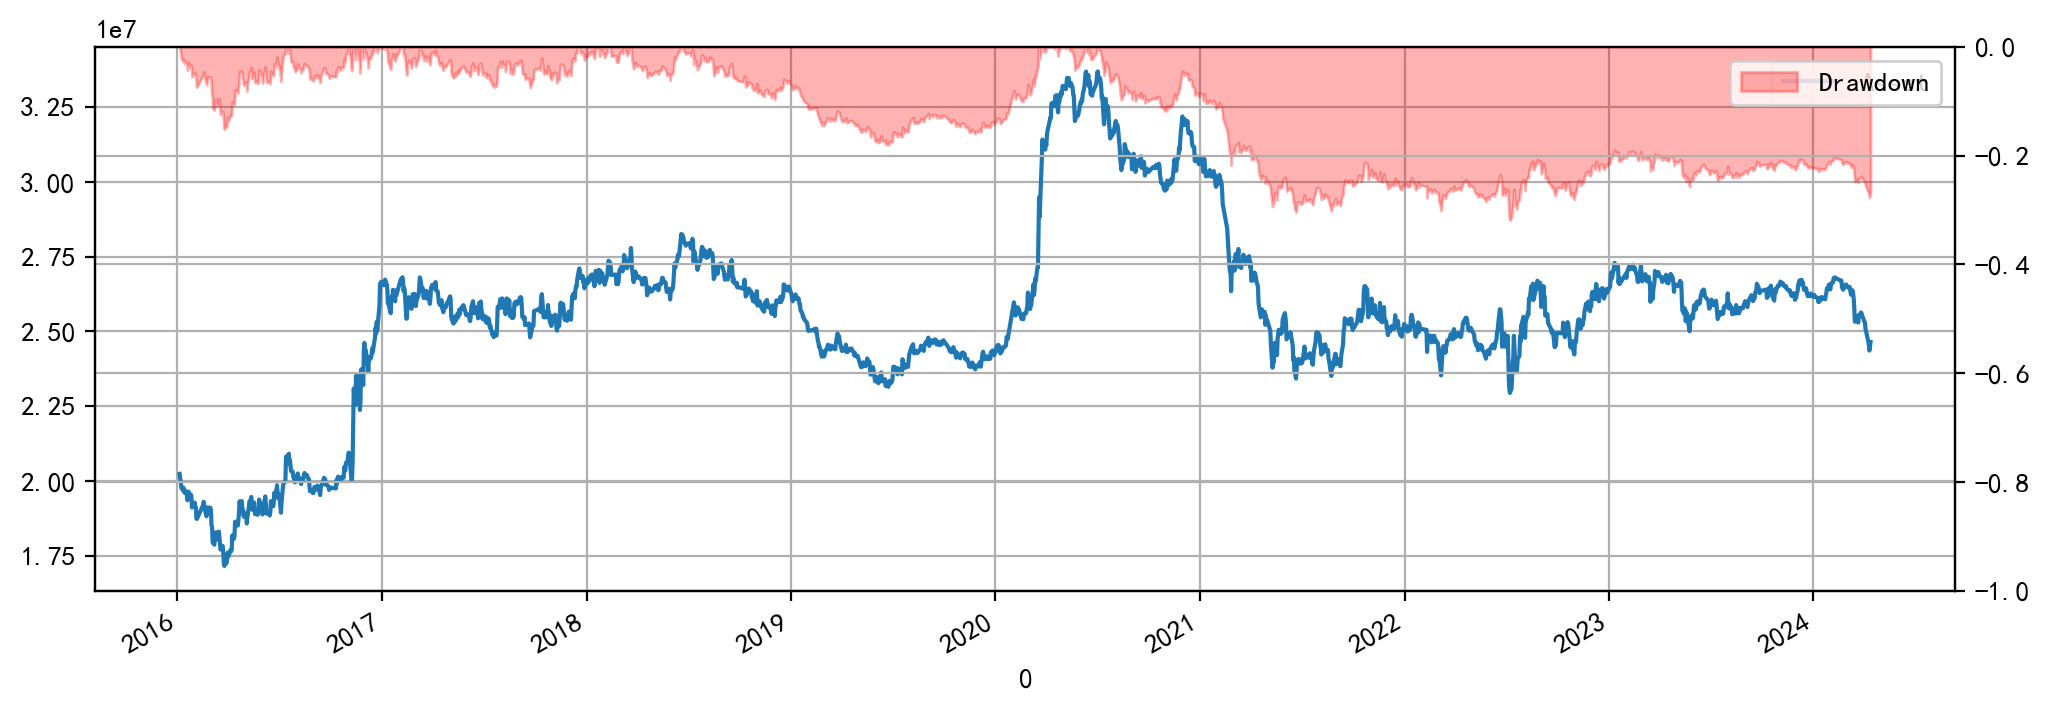

In [ ]:
!python backtest.py "warrant_{variety}" "C:\Users\ifwha\OneDrive - CUHK-Shenzhen\桌面\工作\A06_策略研究\有色黑色对冲\data\position\warrant_{variety}.csv"

nworth = pd.read_csv(f"data/result/warrant_{variety}/历史净值.csv", index_col=0, header=None, parse_dates=True)
strat_test.StratPerf(nworth).plot()

## 勾数据

In [43]:
trade_days = opens.loc['2016-01-01':].index
for v in blist:
    v_posi = pd.DataFrame(1, index=trade_days, columns=[v])
    v_cross = utils.few2crossing(v_posi)
    v_cross.to_csv(f"data/position/{v}_getPrice.csv")
    !python backtest.py "{v}_getPrice" "C:\Users\ifwha\OneDrive - CUHK-Shenzhen\桌面\工作\A06_策略研究\有色黑色对冲\data\position\{v}_getPrice.csv"


保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\FG_getPrice\FG_getPrice_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\FG_getPrice\FG_getPrice_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\FG_getPrice\FG_getPrice.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\FG_getPrice\FG_getPrice.csv
Figure(1200x800)
年化收益率 年化波动率 夏普率 最大回撤  最长回撤期 年换手率
   12.488%    14.868% 0.8399 -31.262%         663  451.35%
保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\hc_getPrice\hc_getPrice_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\hc_getPrice\hc_getPrice_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\hc_getPrice\hc_getPrice.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\hc_getP

In [4]:
web_0950 = pd.DataFrame()

for v in blist:
    try:
        web_0950[v] = pd.read_csv(
            f"data/result/{v}_getPrice/历史净值.csv",
            index_col=0,
            header=None,
            parse_dates=True,
        )[1]
    except:
        continue

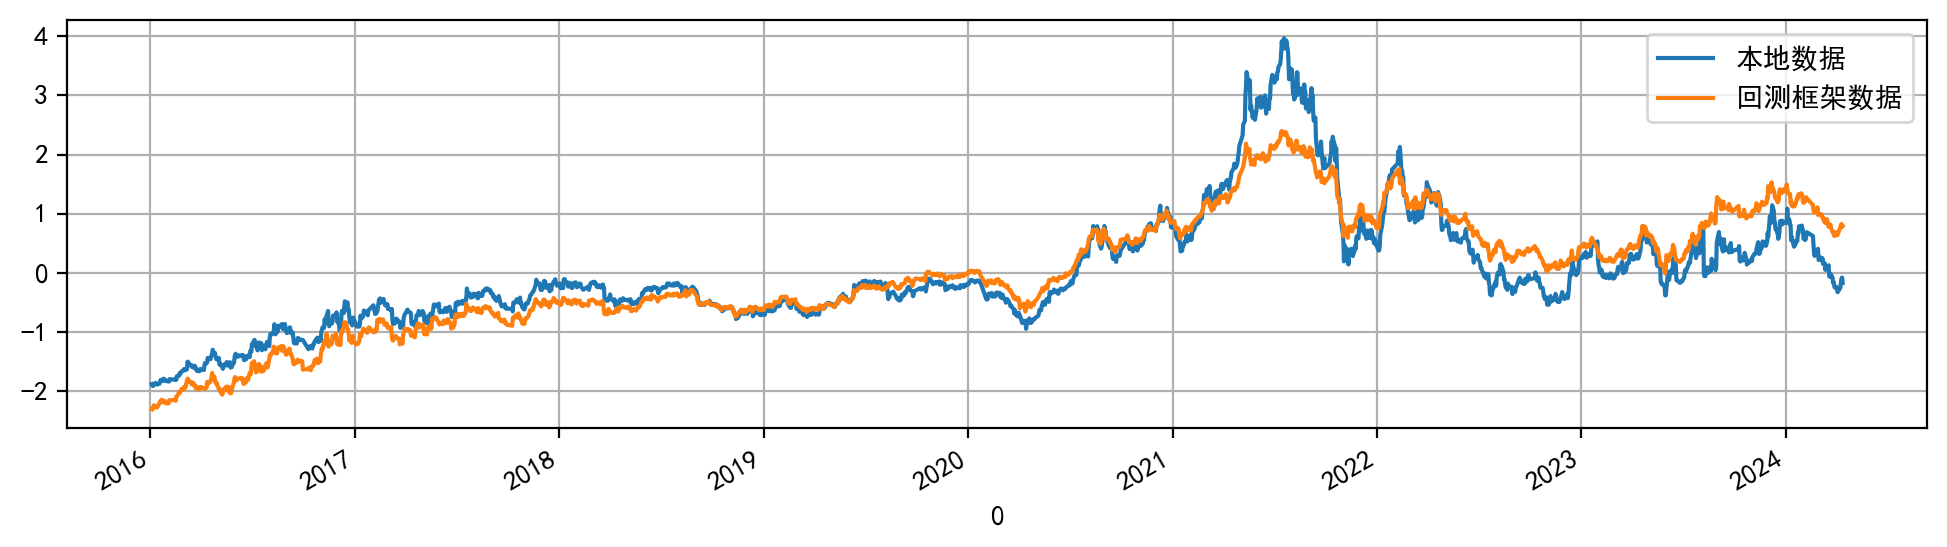

In [8]:
variety = 'FG'

fig, ax = plt.subplots()

utils.scale(opens[variety].loc[start_date:]).plot(ax=ax, label='本地数据')
utils.scale(web_0950[variety]).plot(ax=ax, label='回测框架数据')

plt.legend(['本地数据', '回测框架数据'])

## 截面策略

In [5]:
warrant.loc["2016-02-01":]

,rb,SM,i,SF,hc,j,jm,SA,FG,ss
指标名称,,,,,,,,,,
2024-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-25,42068.0,119681.0,2100.0,5412.0,138350.0,890.0,NaN,3476.0,353.0,193529.0
2024-06-24,42068.0,117904.0,2100.0,5432.0,138350.0,890.0,NaN,3476.0,362.0,191552.0
2024-06-21,42068.0,116404.0,2100.0,0.0,138350.0,890.0,NaN,3866.0,364.0,190707.0
2024-06-20,41767.0,116451.0,2100.0,10036.0,138350.0,940.0,NaN,3951.0,364.0,190310.0
...,...,...,...,...,...,...,...,...,...,...
2016-02-05,37347.0,0.0,NaN,0.0,2062.0,NaN,NaN,NaN,212.0,NaN
2016-02-04,37347.0,0.0,NaN,0.0,2062.0,NaN,NaN,NaN,212.0,NaN
2016-02-03,37347.0,0.0,NaN,0.0,2062.0,NaN,NaN,NaN,212.0,NaN


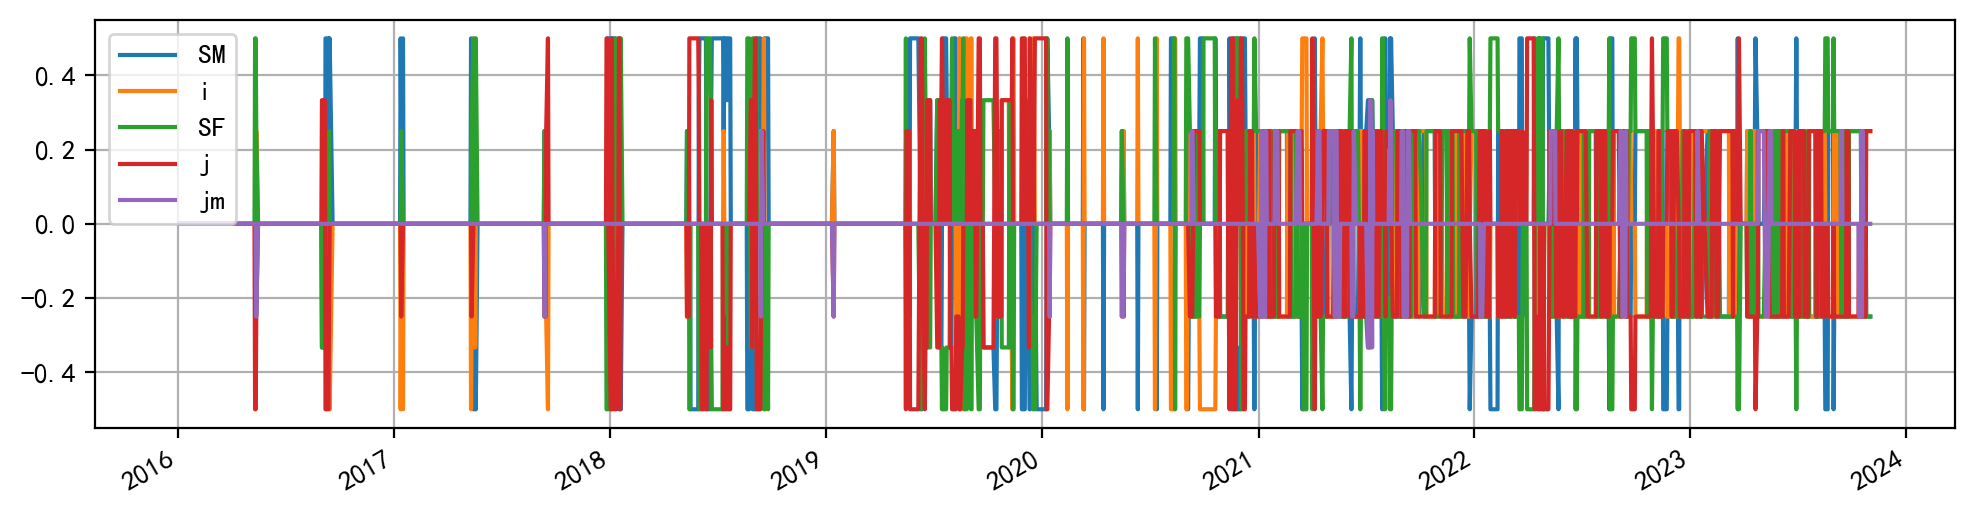

In [23]:
variety = ["SM", "i", "SF", "j", "jm"]

warrant_diff = warrant.diff()
factor = warrant / warrant.rolling(5).mean() - 1

price, fac = opens[variety].align(factor[variety], join='inner')
price = price.loc[start_date:"2023-11-01"]
fac = fac.loc[start_date:"2023-11-01"]
posi = strat_test.Position(fac, 'rank', 2)
posi.get_posi().plot()

networth = strat_test.NetWorth(price, posi, fee=0.0002)

<Axes: >

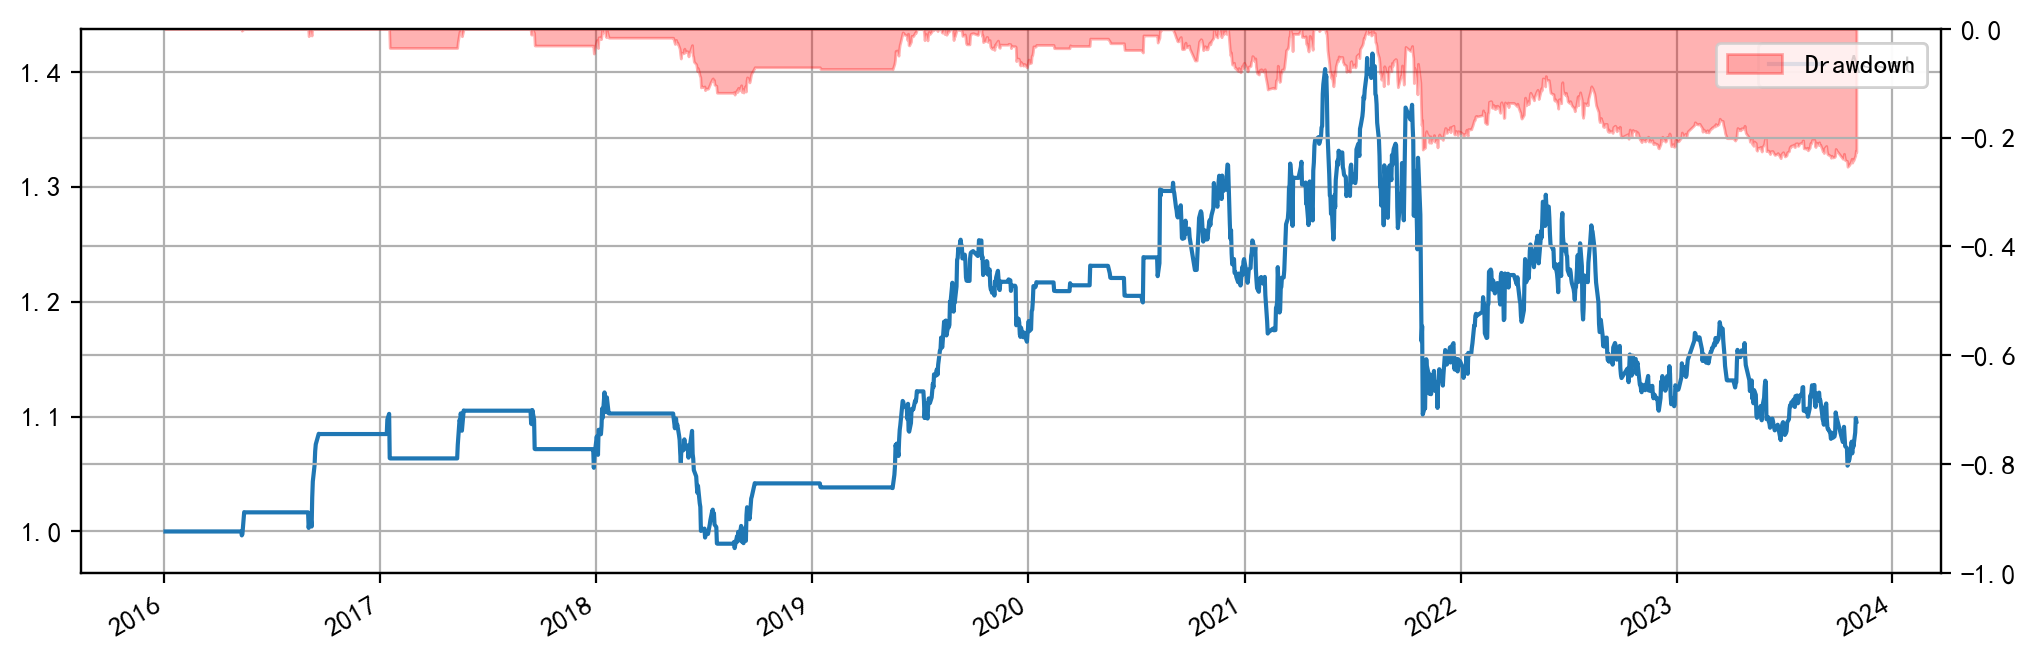

In [24]:
networth.plot()

In [27]:
utils.few2crossing(posi.get_posi()).to_csv(f"data/position/warrant.csv")

保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant\warrant_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant\warrant_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant\warrant.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/有色黑色对冲/data/result\warrant\warrant.csv


Traceback (most recent call last):
  File "backtest.py", line 73, in <module>
    MakeNetWorth(
  File "C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A04_回测框架/截面项目/dataprepare/code\makeNetWorthFuture.py", line 170, in run
    self.checkPosition()
  File "C:\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A04_回测框架/截面项目/dataprepare/code\makeNetWorthFuture.py", line 265, in checkPosition
    nVolume = int(round(self.nInitMoney * nPositionRate / nOPenPositionPrice / nMultiplier, 0))
ValueError: cannot convert float NaN to integer


<Axes: xlabel='0'>

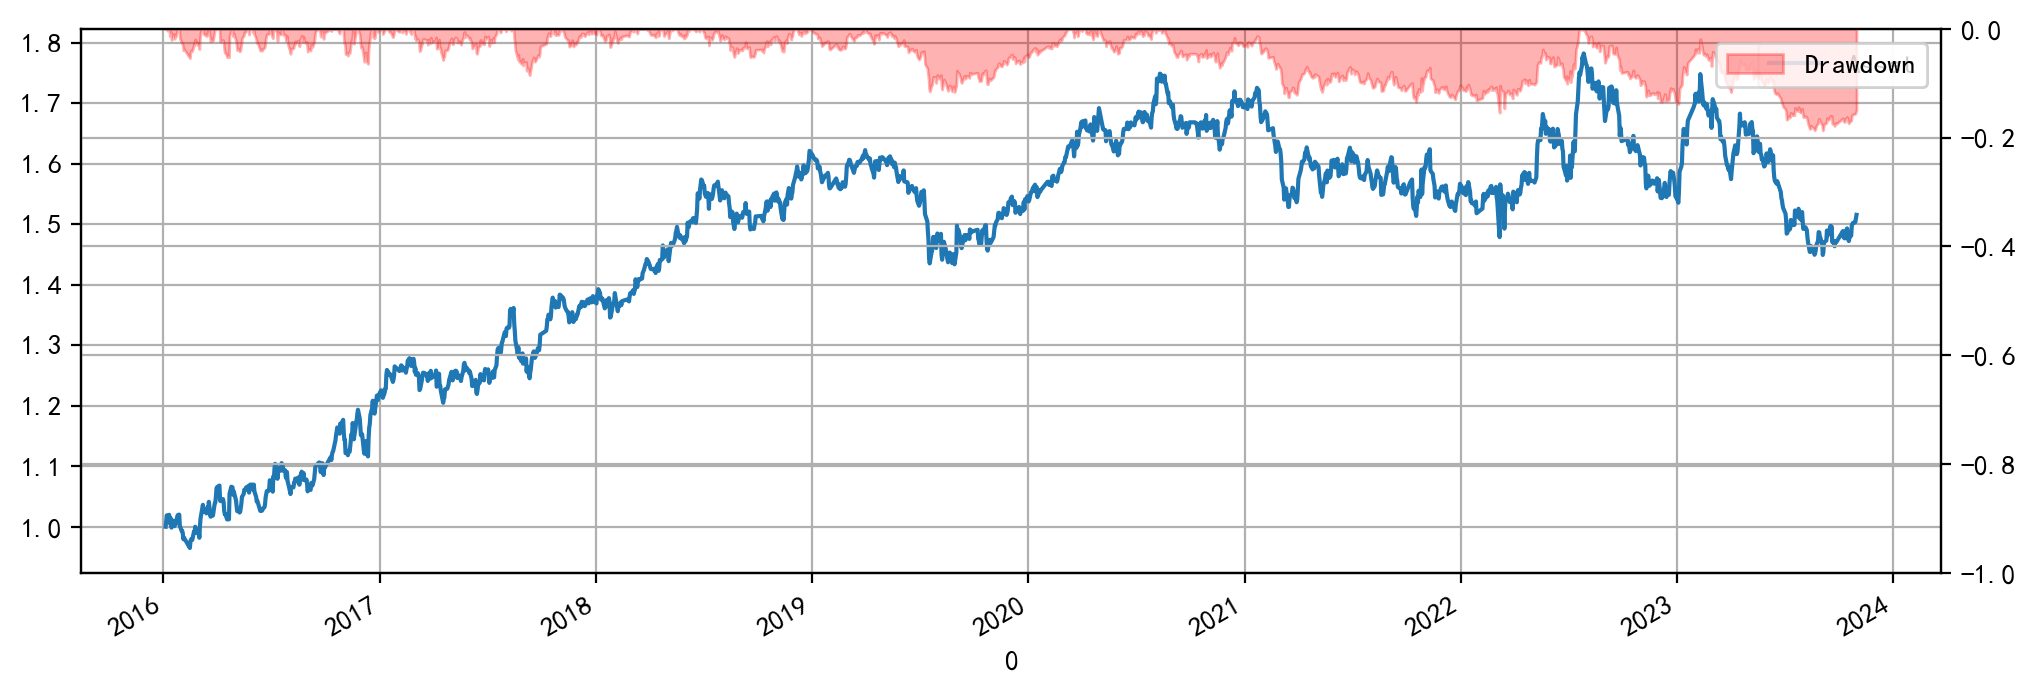

In [28]:
!python backtest.py "warrant" "C:\Users\ifwha\OneDrive - CUHK-Shenzhen\桌面\工作\A06_策略研究\有色黑色对冲\data\position\warrant.csv"

nworth = pd.read_csv(f"data/result/warrant/历史净值.csv", index_col=0, header=None, parse_dates=True)
strat_test.StratPerf(utils.scale(nworth, '1stvalue')).plot()

In [ ]:
strat_test.StratPerf(utils.s cale(nworth, '1stvalue'), posi.get_posi()["2016-01-05":"2023-11-01"]).get_annual()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2016,243,53.91,16.90,15.42,7.07,2.39,1.10,19.99,49.86,50.14,100.0
2017,244,56.56,12.54,10.89,8.78,1.43,1.15,17.93,50.00,50.00,100.0
2018,243,56.79,16.37,9.30,6.64,2.46,1.76,20.88,50.00,50.00,100.0
2019,244,48.77,-5.19,9.59,11.20,-0.46,-0.54,23.98,50.00,50.00,100.0
2020,243,53.91,7.64,10.01,7.56,1.01,0.76,23.33,49.84,50.16,100.0
2021,243,47.74,-4.91,11.50,12.22,-0.40,-0.43,23.87,50.00,50.00,100.0
2022,242,47.11,1.37,14.96,12.00,0.11,0.09,26.45,50.00,50.00,100.0
2023,200,46.00,-0.25,10.80,15.66,-0.02,-0.02,26.12,50.00,50.00,100.0
total,1902,51.63,5.50,12.09,15.66,0.35,0.45,22.78,49.96,50.04,100.0


In [ ]:
nworth

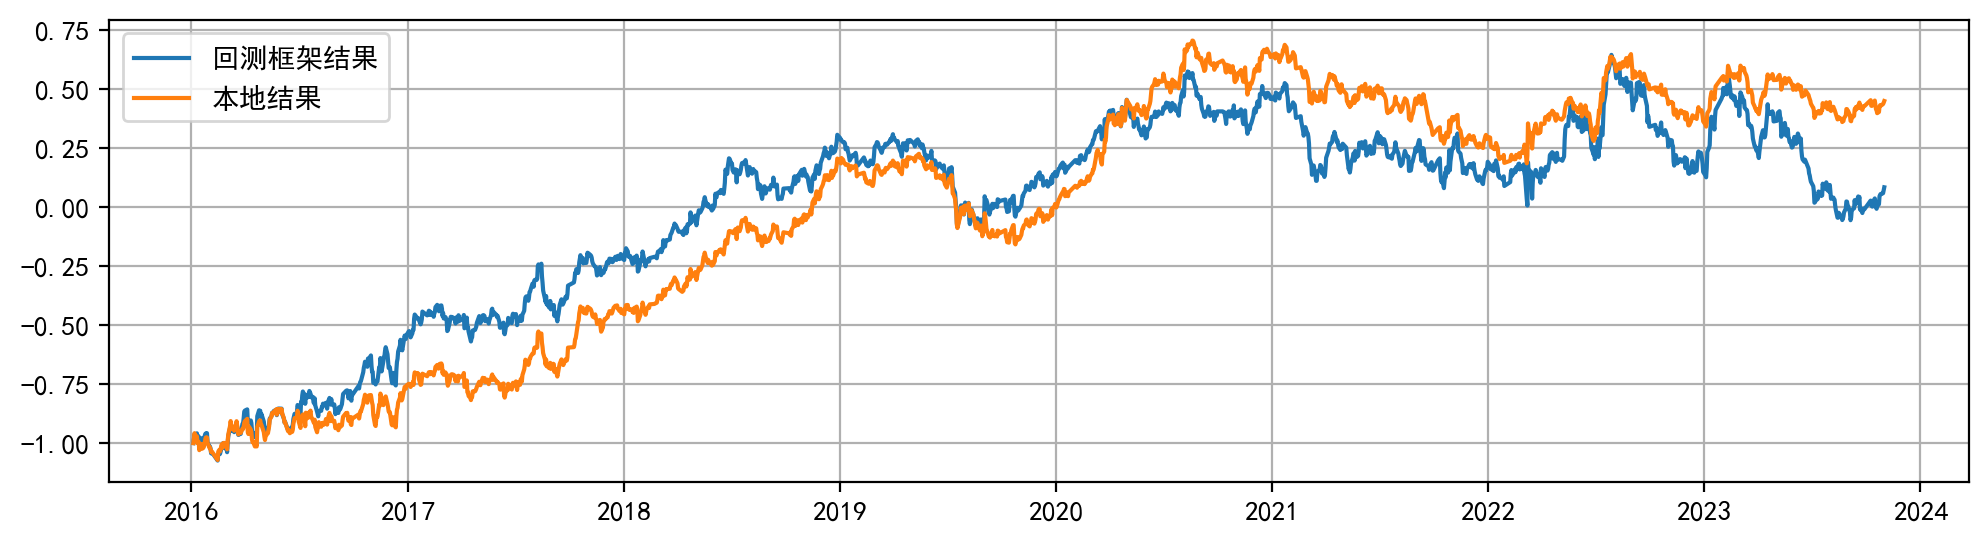

In [ ]:
plt.plot(utils.scale(utils.scale(nworth), '1stvalue'), label='回测框架结果')
plt.plot(utils.scale(utils.scale(networth.networth), '1stvalue'), label='本地结果')

plt.legend()